In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/dataset/S03R01.txt'

df = pd.read_csv(file_path, header=None, sep=' ')

In [ ]:
names = ['Time',
         'Ak_hf','Ak_ve','Ak_hl',
         'Ul_hf','Ul_ve','Ul_hl',
         'Tr_hf','Tr_ve','Tr_hl',
         'Label']

df.columns = names

In [ ]:
df.shape

(144190, 11)

In [ ]:
df.head()

,Time,Ak_hf,Ak_ve,Ak_hl,Ul_hf,Ul_ve,Ul_hl,Tr_hf,Tr_ve,Tr_hl,Label
0,15,80,49,-980,0,0,0,0,0,0,0
1,31,80,49,-980,0,0,0,0,0,0,0
2,46,50,58,-960,0,0,0,0,0,0,0
3,62,50,58,-960,0,0,0,0,0,0,0
4,78,50,58,-960,0,0,0,0,0,0,0


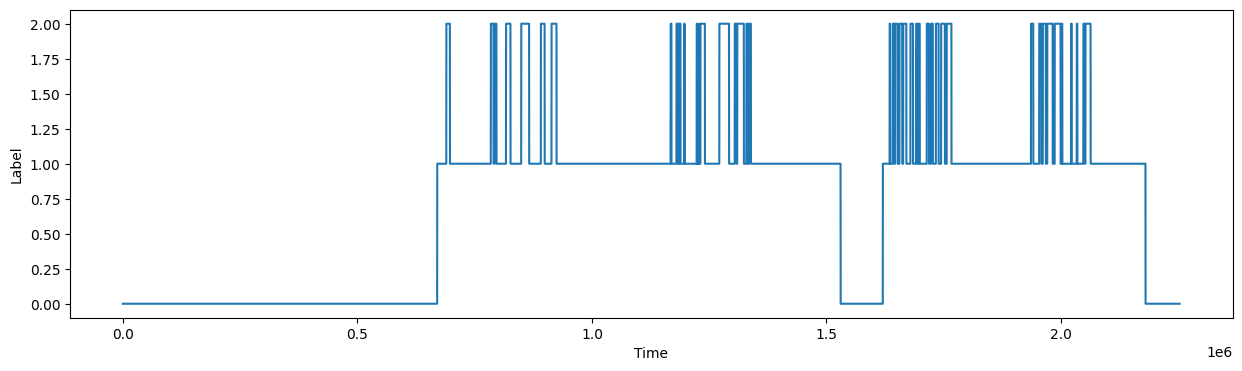

In [ ]:
import seaborn as sns

"""Label status is shown throughout a sample file"""

fig,ax = plt.subplots(figsize=(15,4))
_ = sns.lineplot(data=df, x="Time", y='Label', ax=ax)

In [ ]:
df = df[df['Label'] != 0]

In [ ]:
df['Label'] = df['Label'].replace(1,0)

<ipython-input-9-314c77574127>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].replace(1,0)


In [ ]:
df['Label'] = df['Label'].replace(2,1)

<ipython-input-10-78e0ea893eda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].replace(2,1)


In [ ]:
def graph_data(dataframe_name, attributes, hue_label='Label'):
  fig,axs = plt.subplots(9,1,figsize=(15,15))
  for i, att in enumerate(attributes):
    _ = sns.lineplot(data=dataframe_name, x=dataframe_name.index, y=att, ax=axs[i], hue=hue_label)

In [ ]:
"""Getting only the name of the attributes"""
attributes = names[1:-1]

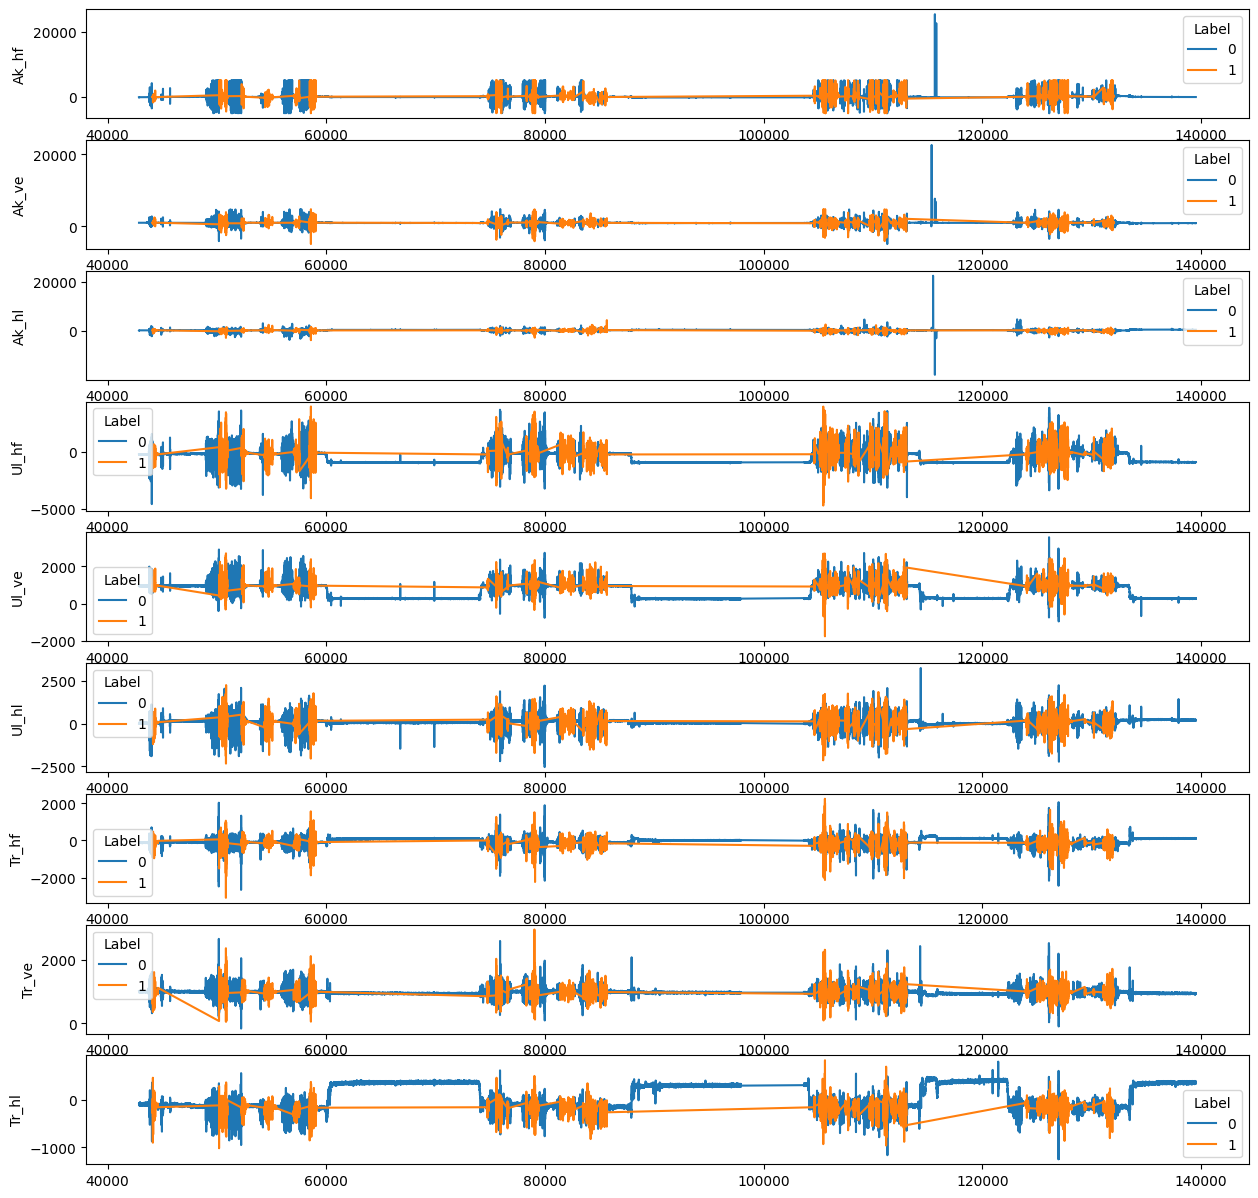

In [ ]:
graph_data(df, attributes)

In [ ]:
df.reset_index(drop=True, inplace=True)
df = df.iloc[:,1:]

In [ ]:
from pathlib import Path

data_directory = '/content/drive/My Drive/dataset'
df_fog = [pd.read_csv(file, header=None, sep=' ') for file in Path(data_directory).iterdir()]
df_fog = pd.concat(df_fog)

In [ ]:
df_fog.columns = names

In [ ]:
df_fog = df_fog[df_fog['Label'] != 0]

In [ ]:
df_fog['Label'] = df_fog['Label'].replace(1,0)

In [ ]:
df_fog['Label'] = df_fog['Label'].replace(2,1)

In [ ]:
df_fog.reset_index(drop=True, inplace=True)
df_fog = df_fog.iloc[:,1:]

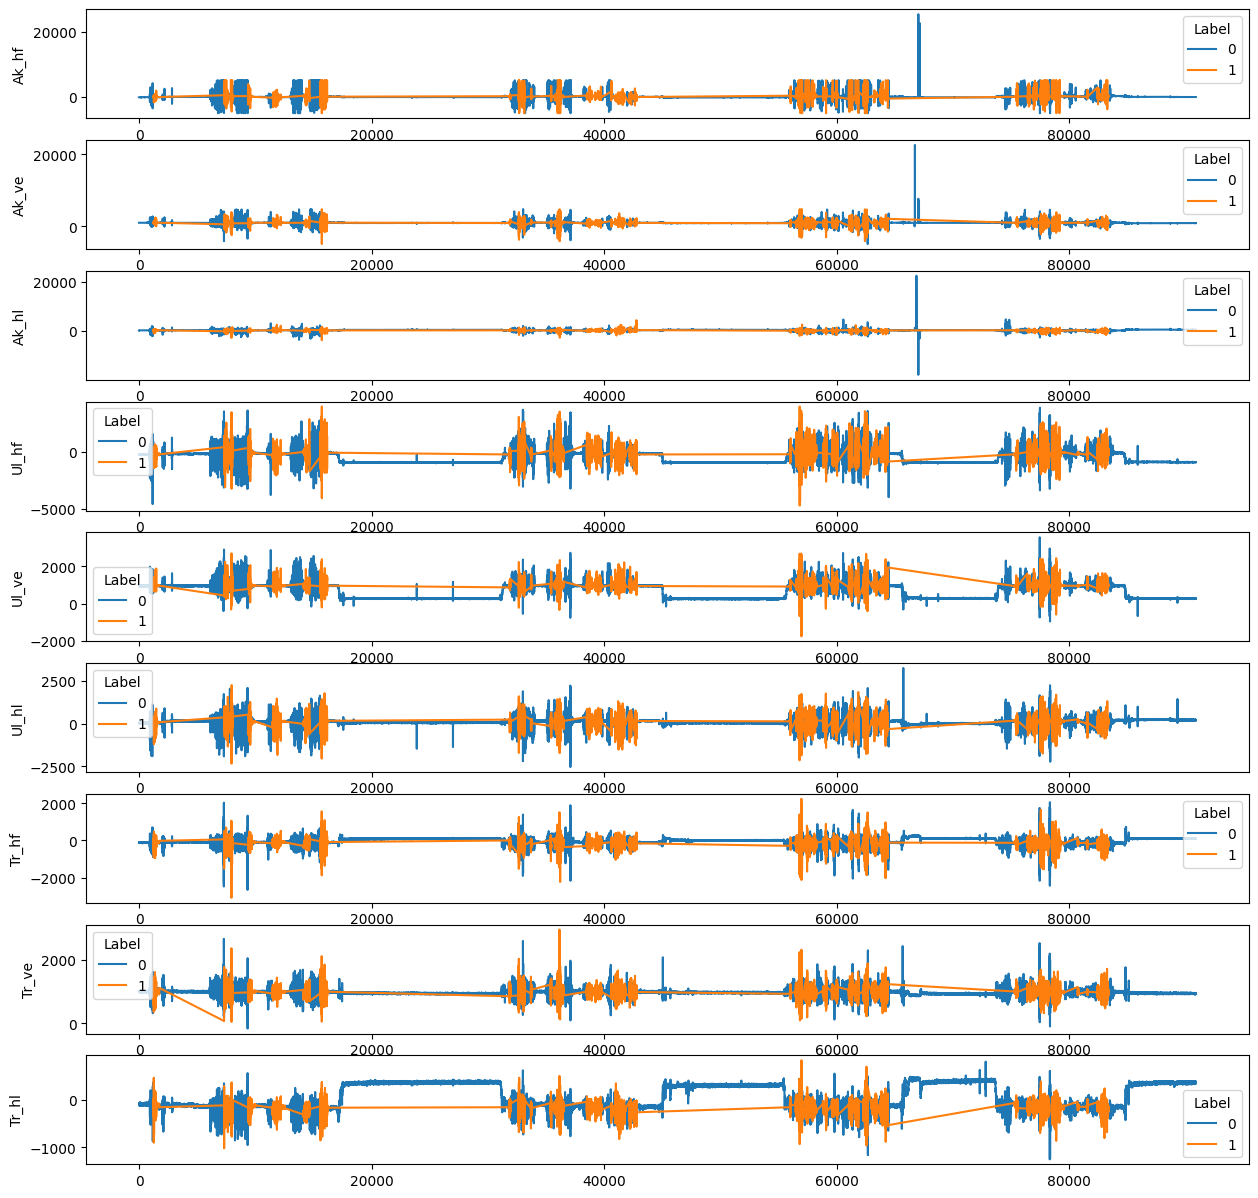

In [ ]:
graph_data(df, attributes)

In [ ]:
q1_data = []
q3_data = []
iqr_data = []

mean_attribute_data = []

for attr in attributes:
  q3 = df_fog[attr].quantile(0.75)
  q1 = df_fog[attr].quantile(0.25)
  iqr = q3 - q1

  non_extreme = df_fog[
      (df_fog[attr] < (q3 + 1.5*iqr)) & (df_fog[attr] > (q1 - 1.5*iqr))
    ]

  mean_attribute = round(non_extreme[attr].mean())

  '''Adding values to lists'''
  q1_data.append(q1)
  q3_data.append(q3)
  iqr_data.append(iqr)

  mean_attribute_data.append(mean_attribute)
  ''''''

  extreme = df_fog[
      (df_fog[attr] > (q3 + 1.5*iqr)) | (df_fog[attr] < (q1 - 1.5*iqr))
    ]

  df_fog[attr].replace(
      to_replace=extreme[attr].unique(),
      value=mean_attribute,
      inplace=True
      )

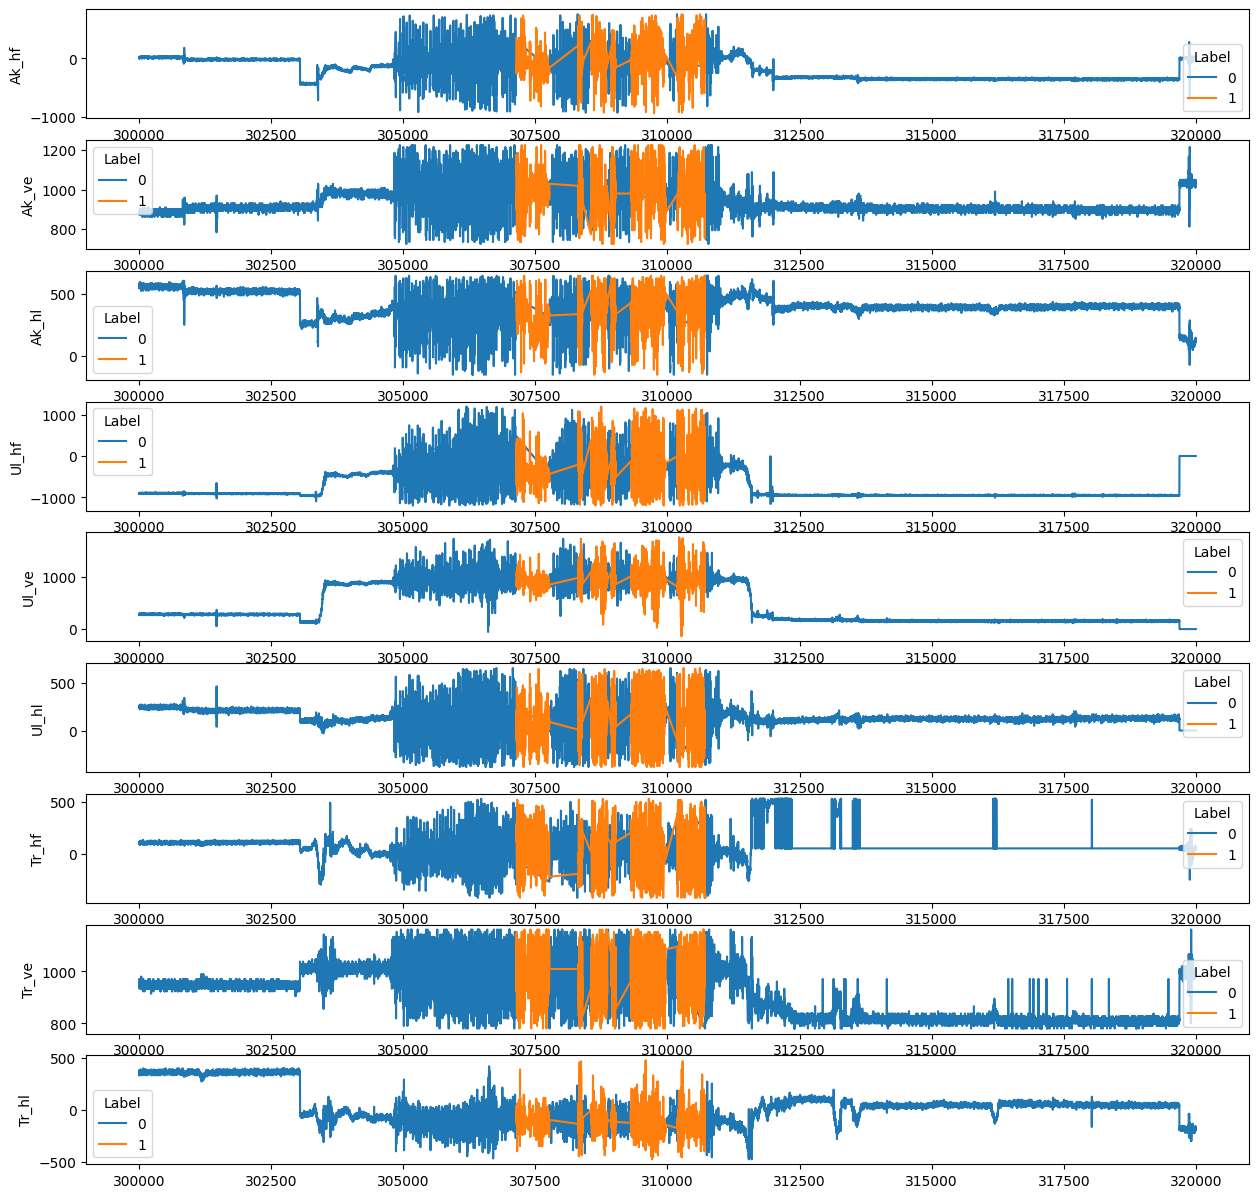

In [ ]:
graph_data(df_fog[300000:320000], attributes)

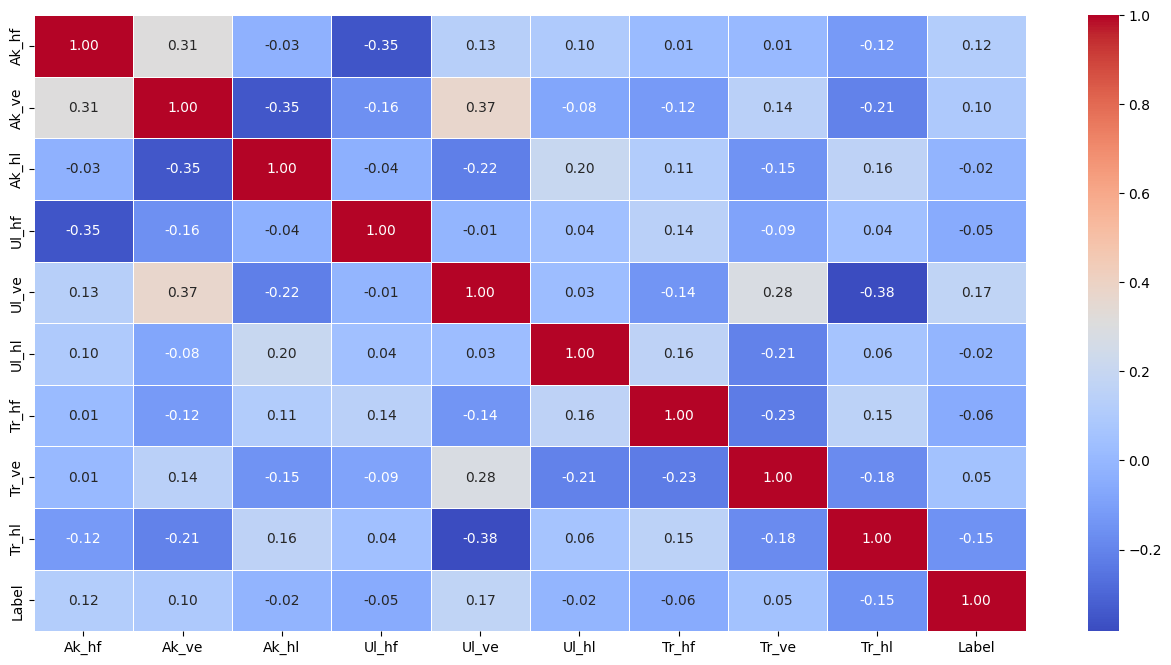

In [ ]:
corr_matrix = df_fog.corr(method='spearman')
fig,ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

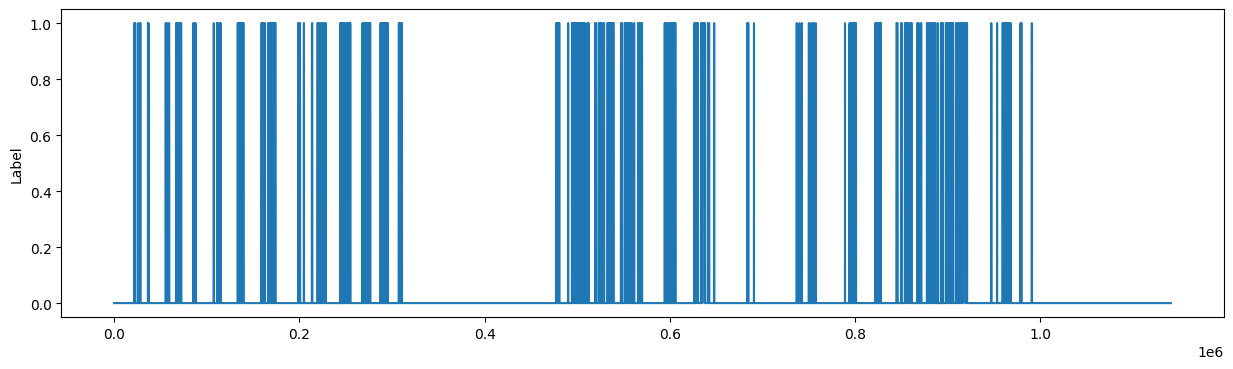

In [ ]:
"""
Status of labels for the entire dataset:
- 0: No FoG
- 1: FoG
"""

fig,ax = plt.subplots(figsize=(15,4))
_ = sns.lineplot(data=df_fog, x=df_fog.index, y='Label', ax=ax)

In [ ]:
train_total = round(len(df_fog) * 0.80)
test_total = round(len(df_fog) * 0.20)

print("Total data: {}".format(len(df_fog)))
print("Total training data: {}".format(train_total))
print("Total testing data: {}".format(test_total))

Total data: 1140835
Total training data: 912668
Total testing data: 228167


In [ ]:
train = df_fog.iloc[:train_total]
test = df_fog.iloc[train_total:]

In [ ]:
time_step = 30

last_train = train.iloc[-(time_step-1):]
test = pd.concat([last_train, test], axis=0)

In [ ]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_x = test.iloc[:,:-1]
test_y = test.iloc[time_step-1:,-1]

In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))
train_x_sc = sc.fit_transform(train_x)

In [ ]:
test_x_sc = sc.transform(test_x)

In [ ]:
# Training
df_train_sc = pd.DataFrame(train_x_sc,
                          columns = train_x.columns)
df_train_sc = pd.concat([df_train_sc, train_y], axis=1)

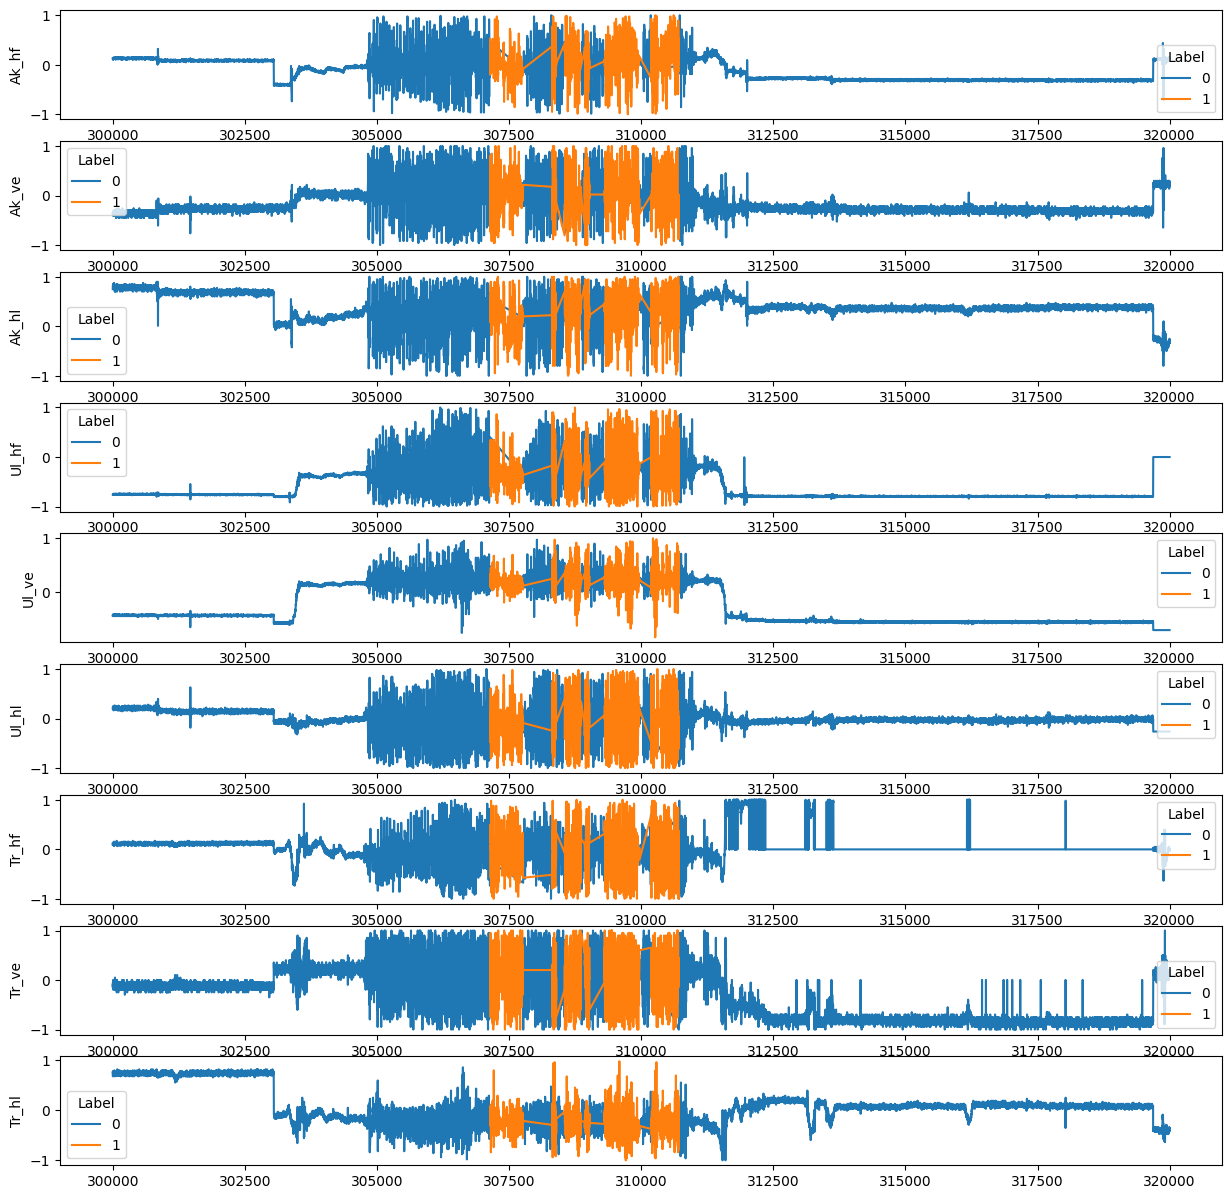

In [ ]:
graph_data(df_train_sc[300000:320000], attributes)

In [ ]:
# Testing
df_test_sc = pd.DataFrame(test_x_sc,
                          columns = test_x.columns)
df_test_sc = df_test_sc.iloc[time_step-1:,:].reset_index(drop=True)
df_test_sc = pd.concat([df_test_sc, test_y.reset_index(drop=True)], axis=1)

In [ ]:
# Training dataset
x_train = []
y_train = []

for i in range(time_step, train_y.shape[0]):
  x_train.append(train_x_sc[i-time_step:i])
  y_train.append(train_y[i-1])

x_train, y_train = np.array(x_train), np.array(y_train)
y_train = np.expand_dims(y_train, axis=1)

In [ ]:
# Testing dataset
x_test = []
y_test = []

for i in range(time_step, test_y.shape[0]):
  x_test.append(test_x_sc[i-time_step:i])
  y_test.append(test_y.values[i-1])

x_test, y_test = np.array(x_test), np.array(y_test)
y_test = np.expand_dims(y_test, axis=1)

In [ ]:
# Constants for LSTM model
time_step = 30
N = 9
LR = 5e-2
LAMBD = 3e-2
DP = 0.0
RDP = 0.0
LAYERS_LSTM = [8, 8, 8, 1]

# Constants for CNN model
KERNEL_SIZE = 3
POOL_SIZE = 2
FILTERS = 16
LAYERS_CNN = [32, 64, 128]

In [ ]:
num_models = 3

In [ ]:
def create_lstm_model(time_step, num_features):
    model = Sequential()
    model.add(LSTM(units=8, input_shape=(time_step, num_features), activation='tanh',
                   recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.03),
                   recurrent_regularizer=l2(0.03), dropout=0.0, recurrent_dropout=0.0,
                   return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=8, activation='tanh', recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(0.03), recurrent_regularizer=l2(0.03), dropout=0.0,
                   recurrent_dropout=0.0, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=8, activation='tanh', recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(0.03), recurrent_regularizer=l2(0.03), dropout=0.0,
                   recurrent_dropout=0.0, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.05))
    return model


In [ ]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu', input_shape=(time_step, N)))
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(Conv1D(filters=FILTERS*2, kernel_size=KERNEL_SIZE, activation='relu'))
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(Conv1D(filters=FILTERS*4, kernel_size=KERNEL_SIZE, activation='relu'))
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(learning_rate=LR))

    return model

In [ ]:
lstm_models = [create_lstm_model(time_step=30, num_features=9) for _ in range(num_models)]
cnn_models = [create_cnn_model() for _ in range(num_models)]


In [ ]:
for i in range(num_models):
    lstm_models[i].fit(x_train, y_train, epochs=3, batch_size=300, validation_split=0.1, verbose=1)
    cnn_models[i].fit(x_train, y_train, epochs=3, batch_size=300, validation_split=0.1, verbose=1)



Epoch 1/3
2738/2738 [==============================] - 244s 89ms/step - loss: 0.2686 - accuracy: 0.9042 - val_loss: 0.6910 - val_accuracy: 0.7639
Epoch 2/3
2738/2738 [==============================] - 245s 90ms/step - loss: 0.2580 - accuracy: 0.9054 - val_loss: 0.7189 - val_accuracy: 0.7374
Epoch 3/3
2738/2738 [==============================] - 244s 89ms/step - loss: 0.2569 - accuracy: 0.9056 - val_loss: 0.6775 - val_accuracy: 0.7582
Epoch 1/3
2738/2738 [==============================] - 45s 15ms/step - loss: 0.2143 - accuracy: 0.9052 - val_loss: 0.5603 - val_accuracy: 0.7639
Epoch 2/3
2738/2738 [==============================] - 41s 15ms/step - loss: 0.1993 - accuracy: 0.9065 - val_loss: 0.6769 - val_accuracy: 0.7639
Epoch 3/3
2738/2738 [==============================] - 44s 16ms/step - loss: 0.1975 - accuracy: 0.9056 - val_loss: 0.5759 - val_accuracy: 0.7639
Epoch 1/3
2738/2738 [==============================] - 258s 91ms/step - loss: 0.2758 - accuracy: 0.9039 - val_loss: 0.8828 - va

In [ ]:
lstm_predictions = np.mean([model.predict(x_test) for model in lstm_models], axis=0)
cnn_predictions = np.mean([model.predict(x_test) for model in cnn_models], axis=0)


7130/7130 [==============================] - 17s 2ms/step


In [ ]:
ensemble_predictions = (lstm_predictions + cnn_predictions) / 2.0


In [ ]:
ensemble_binary_predictions = np.round(ensemble_predictions)


In [ ]:
ensemble_binary_predictions = ensemble_binary_predictions[:len(y_test)]



In [ ]:
ensemble_accuracy = accuracy_score(y_test, ensemble_binary_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy * 100:.4f}%')

Ensemble Accuracy: 95.6566%


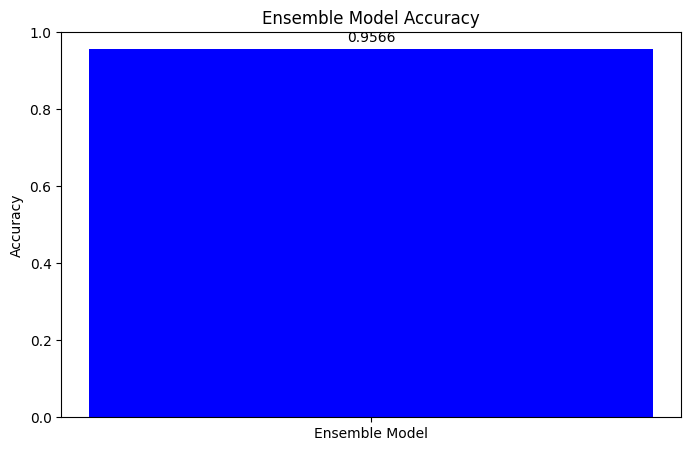

In [ ]:
import matplotlib.pyplot as plt

model_names = ["Ensemble Model"]
accuracies = [ensemble_accuracy]

# Define colors for each bar
bar_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=bar_colors)

plt.title('Ensemble Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{accuracies[i]:.4f}', ha='center', va='bottom')

plt.show()
